# **Masterclass: AutoMl y Ensamblajes de Modelos**

In [ ]:
%%capture
%pip install -q pandas==2.2.2 lightgbm==4.5.0 catboost==1.2.7 xgboost==2.1.3 optuna==4.1.0 shap==0.46.0 cloudpickle==3.0.0 pyarrow==17.0.0 scikit-learn==1.5.2 scipy==1.10.1 dask-expr==2.0.0 dask
%pip install -q setuptools==75.6.0 wheel==0.42.0 autogluon==1.2 autogluon.eda ipywidgets==8.1.5
%pip install -q requests==2.31.0 tabulate==0.9.0 future==1.0.0
%pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

In [1]:
# Basic Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm 
import cloudpickle
import sys
import warnings
import os
import gc

# Autogluon imports
from autogluon.tabular import TabularDataset, TabularPredictor
import autogluon.eda.auto as auto

# Relevant Imports
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go
from IPython.display import Image
from ipywidgets import interact, interactive, fixed, interact_manual

# Seteo de plotly para gráficos
pd.options.plotting.backend = "plotly"
pio.templates.default = "simple_white"
warnings.filterwarnings('ignore')

tqdm.pandas(leave = False)

# **Data**

In [2]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')
train.head()

,id,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,...,bid2vol,bid3vol,bid4vol,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol,y
0,0,3842.4,3842.6,NaN,NaN,103.0,0,3842.4,3842.0,3841.8,...,1,6,14,6,6,1,1,10,2,1
1,1,3842.8,3843.4,6.0,49.0,55.0,-43,3843.0,3842.8,3842.4,...,6,11,1,6,1,4,4,1,13,0
2,2,3844.0,3844.3,7.0,77.0,84.0,-69,3843.8,3843.6,3843.2,...,1,4,21,12,1,16,10,4,9,0
3,3,3843.8,3843.4,3.0,34.0,37.0,-30,3843.0,3842.8,3842.4,...,13,12,2,4,2,7,1,2,11,1
4,4,3843.2,3843.1,3.0,38.0,41.0,-35,3842.8,3842.4,3842.0,...,12,2,2,4,1,3,1,11,15,1


In [3]:
# Basic EDA
print("\nTrain Dataset Shape:", train.shape)
print("\nTest Dataset Shape:", test.shape)

print("\nColumns in the dataset:")
for col in train.columns:
    print(f"- {col}")

print("\nMissing values in Train:")
print(train.isnull().sum()[train.isnull().sum() > 0])



Train Dataset Shape: (592380, 28)

Test Dataset Shape: (191859, 27)

Columns in the dataset:
- id
- last_price
- mid
- opened_position_qty 
- closed_position_qty
- transacted_qty
- d_open_interest
- bid1
- bid2
- bid3
- bid4
- bid5
- ask1
- ask2
- ask3
- ask4
- ask5
- bid1vol
- bid2vol
- bid3vol
- bid4vol
- bid5vol
- ask1vol
- ask2vol
- ask3vol
- ask4vol
- ask5vol
- y

Missing values in Train:
opened_position_qty     172460
closed_position_qty     172460
dtype: int64


: 

# **AutoEDA Autogluon**

## **Overview**

**`train_data` dataset summary (sample size: 10000)**

,count,mean,std,min,25%,50%,75%,max,dtypes,unique,missing_count,missing_ratio,raw_type,variable_type,special_types
ask1,10000,3965.821500,81.644086,3814.8,3896.60,3984.2,4040.20,4114.6,float64,1264,,,float,numeric,
ask1vol,10000,3.905900,4.576979,1.0,1.00,2.0,5.00,74.0,int64,47,,,int,numeric,
ask2,10000,3966.059640,81.650049,3815.0,3896.80,3984.4,4040.45,4114.8,float64,1256,,,float,numeric,
ask2vol,10000,4.890900,5.529906,1.0,2.00,3.0,6.00,106.0,int64,54,,,int,numeric,
ask3,10000,3966.284960,81.655701,3815.2,3897.00,3984.6,4040.80,4115.0,float64,1251,,,float,numeric,
ask3vol,10000,5.300800,6.092785,1.0,2.00,4.0,6.00,93.0,int64,67,,,int,numeric,
ask4,10000,3966.508600,81.662901,3815.4,3897.20,3984.8,4041.00,4115.4,float64,1252,,,float,numeric,
ask4vol,10000,5.595400,6.442348,1.0,2.00,4.0,7.00,127.0,int64,67,,,int,numeric,
ask5,10000,3966.729240,81.669544,3815.6,3897.40,3985.0,4041.20,4115.6,float64,1250,,,float,numeric,
ask5vol,10000,5.924900,7.016993,1.0,2.00,4.0,7.00,134.0,int64,65,,,int,numeric,


**`test_data` dataset summary (sample size: 10000)**

,count,mean,std,min,25%,50%,75%,max,dtypes,unique,missing_count,missing_ratio,raw_type,variable_type,special_types
ask1,10000,5181.391780,46.402012,5070.2,5149.0,5175.8,5223.80,5277.4,float64,978,,,float,numeric,
ask1vol,10000,3.010300,4.010786,1.0,1.0,2.0,3.00,78.0,int64,47,,,int,numeric,
ask2,10000,5181.717520,46.407405,5070.4,5149.2,5176.2,5224.20,5277.6,float64,970,,,float,numeric,
ask2vol,10000,3.340700,4.533815,1.0,1.0,2.0,4.00,92.0,int64,48,,,int,numeric,
ask3,10000,5182.018160,46.414888,5070.6,5149.6,5176.4,5224.60,5277.8,float64,970,,,float,numeric,
ask3vol,10000,3.552800,4.926037,1.0,1.0,2.0,4.00,92.0,int64,55,,,int,numeric,
ask4,10000,5182.313580,46.420737,5071.0,5149.8,5176.8,5224.80,5278.0,float64,970,,,float,numeric,
ask4vol,10000,3.800100,5.232731,1.0,1.0,2.0,4.00,98.0,int64,57,,,int,numeric,
ask5,10000,5182.606560,46.428238,5071.4,5150.0,5177.0,5225.00,5278.6,float64,975,,,float,numeric,
ask5vol,10000,4.020100,6.182242,1.0,1.0,2.0,4.00,103.0,int64,68,,,int,numeric,


**Types warnings summary**

,train_data,test_data,warnings
y,int,--,warning


### Feature Distance

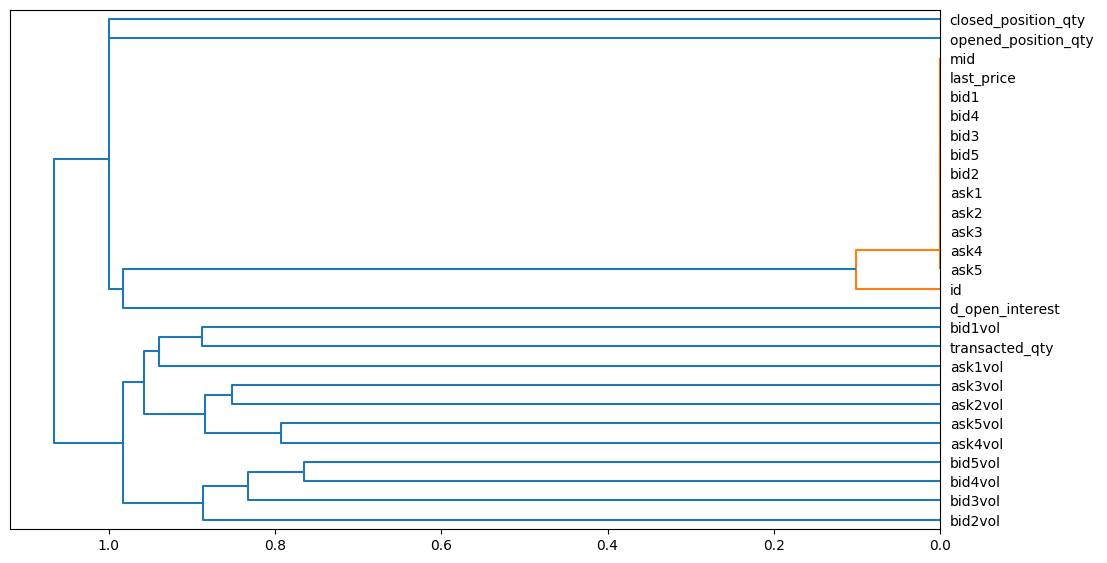

**The following feature groups are considered as near-duplicates**:

Distance threshold: <= `0.01`. Consider keeping only some of the columns within each group:

 - `ask1`, `ask2`, `ask3`, `ask4`, `ask5`, `bid1`, `bid2`, `bid3`, `bid4`, `bid5`, `last_price`, `mid` - distance `0.00`

Feature interaction between `ask1`/`ask2`

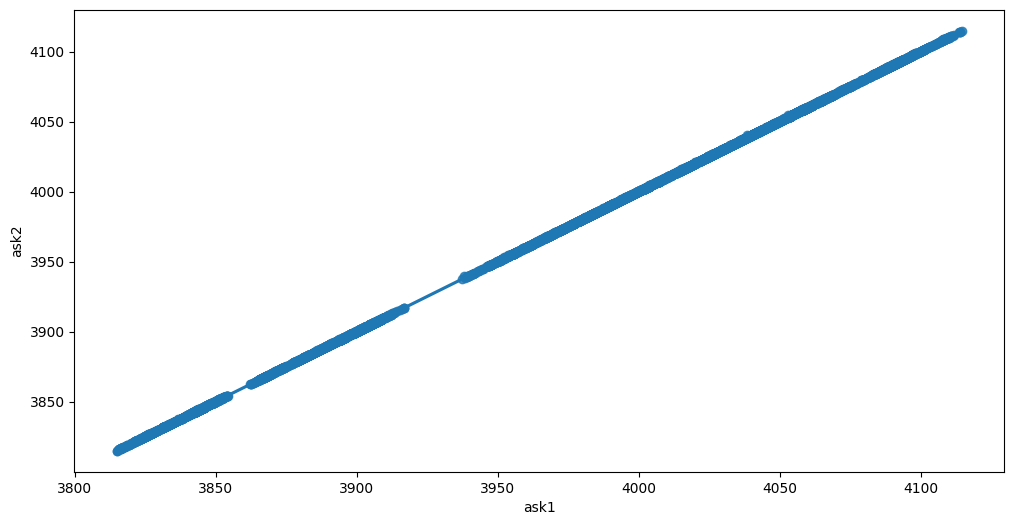

Feature interaction between `ask1`/`ask3`

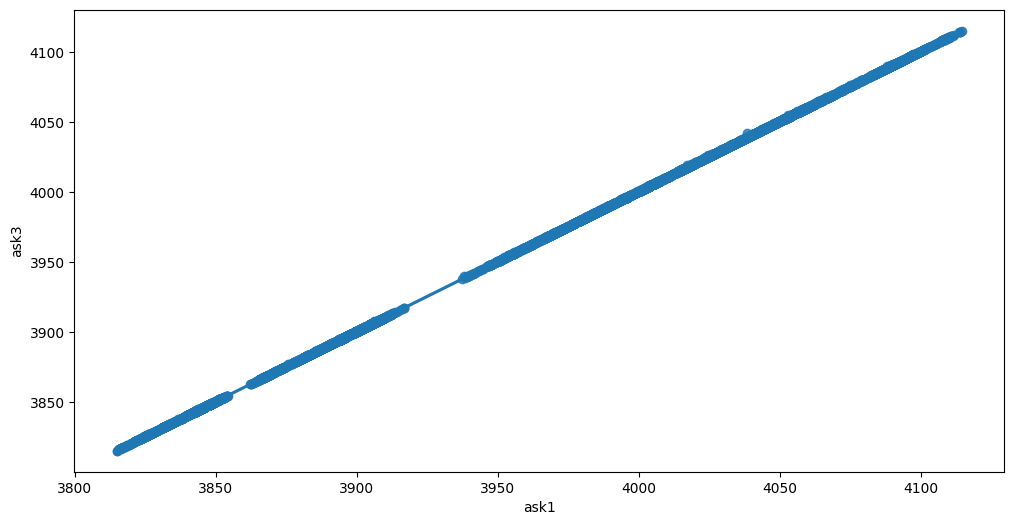

Feature interaction between `ask1`/`ask4`

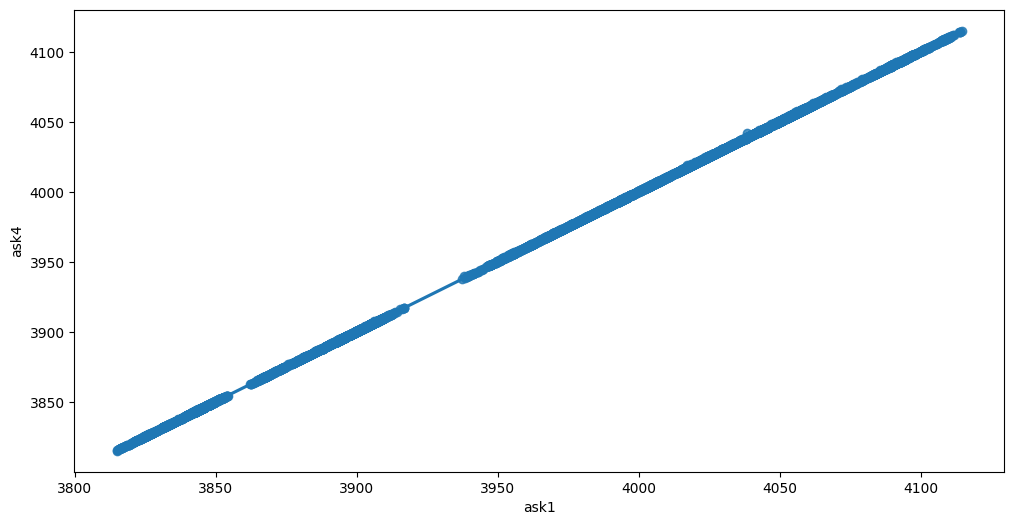

Feature interaction between `ask1`/`ask5`

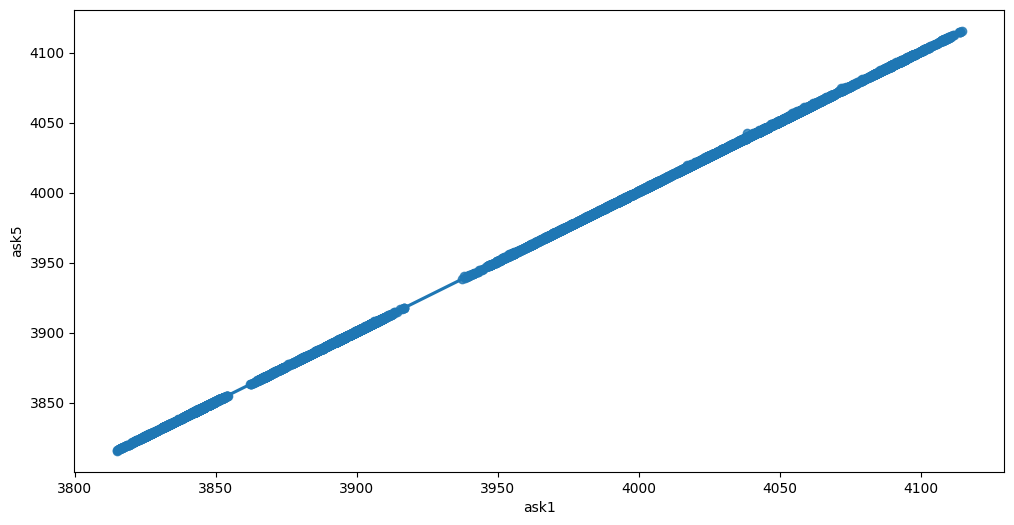

Feature interaction between `ask1`/`bid1`

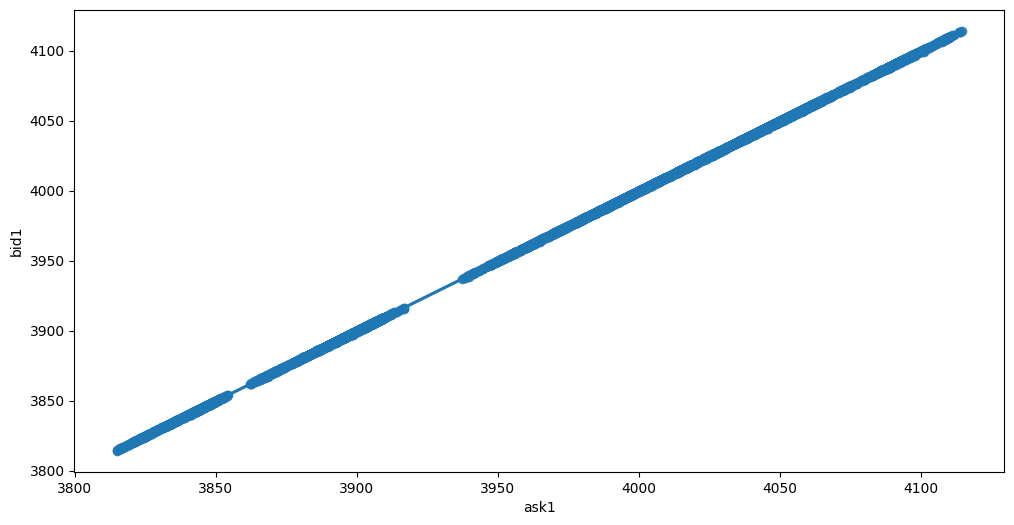

Feature interaction between `ask1`/`bid2`

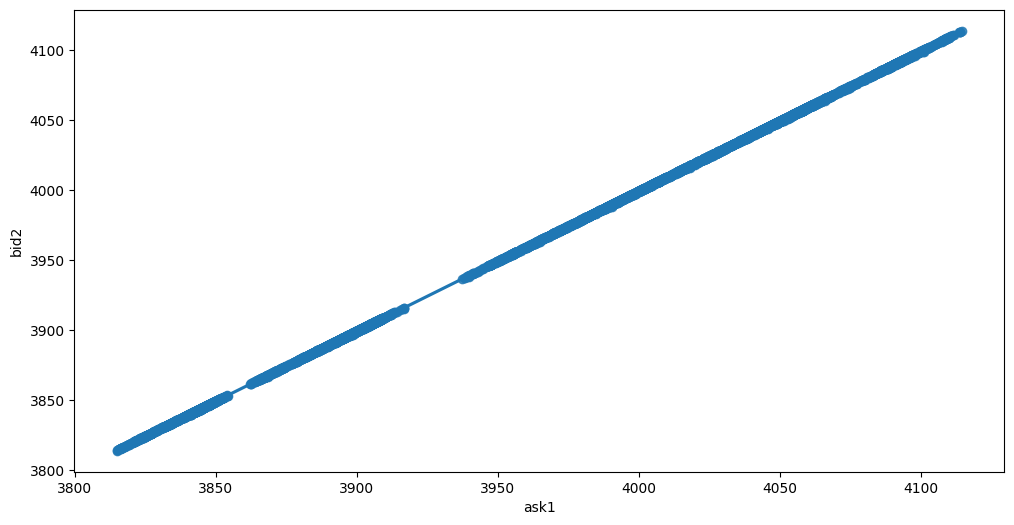

Feature interaction between `ask1`/`bid3`

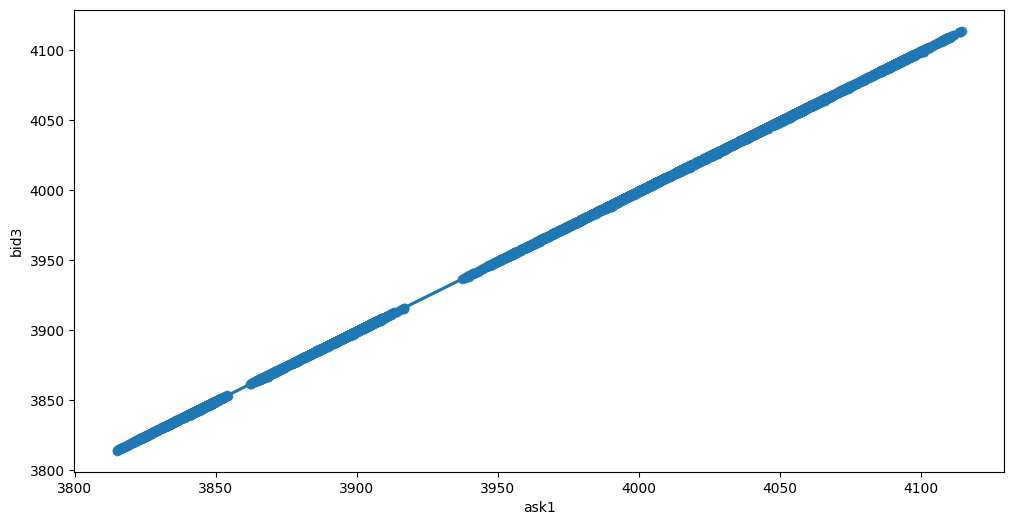

Feature interaction between `ask1`/`bid4`

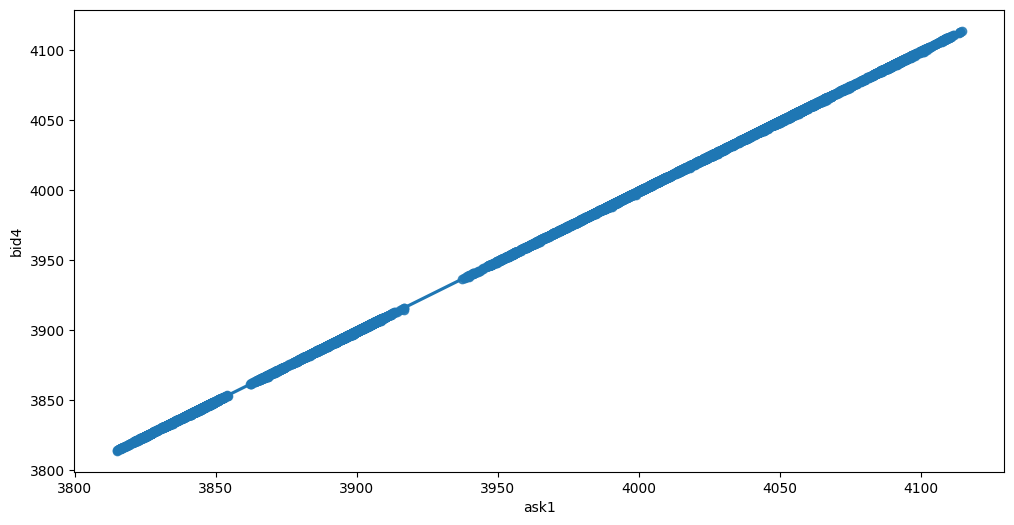

Feature interaction between `ask1`/`bid5`

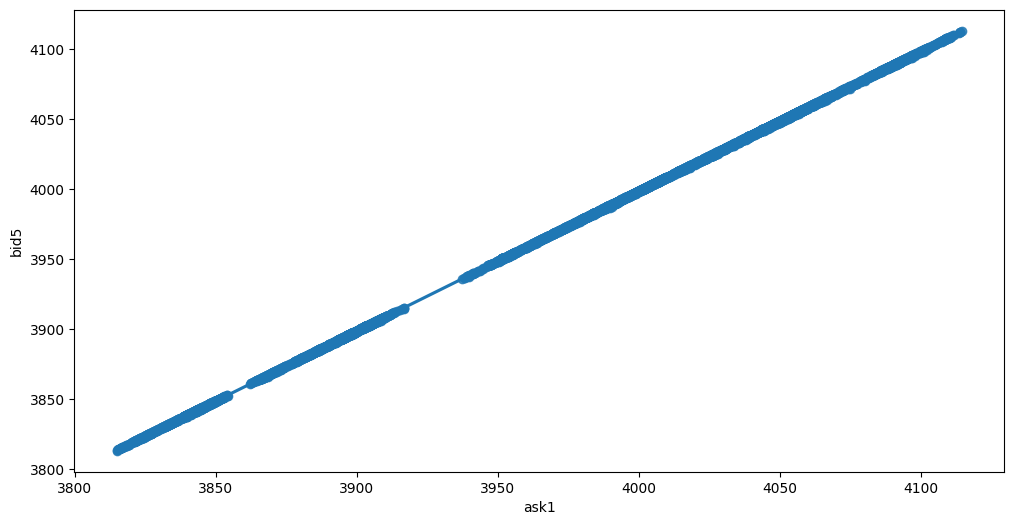

Feature interaction between `ask1`/`last_price`

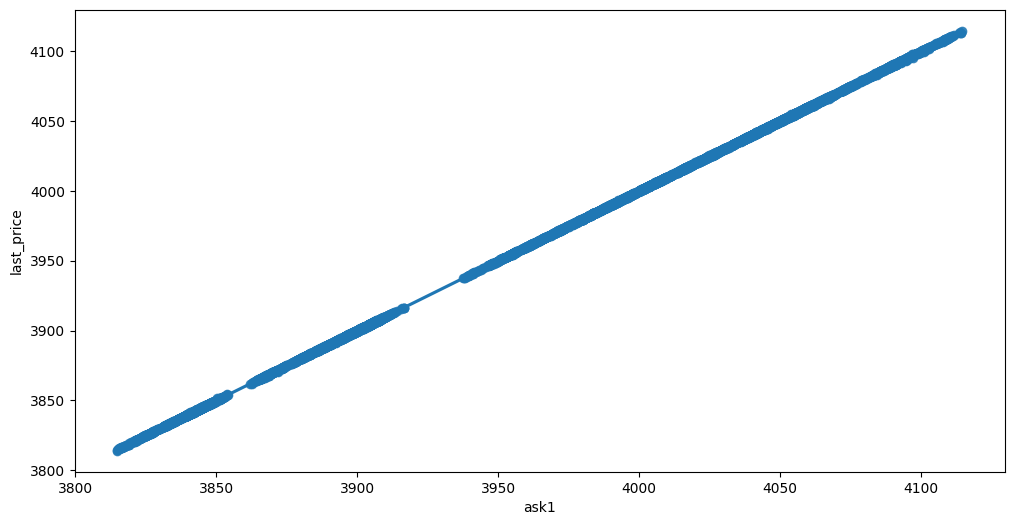

Feature interaction between `ask1`/`mid`

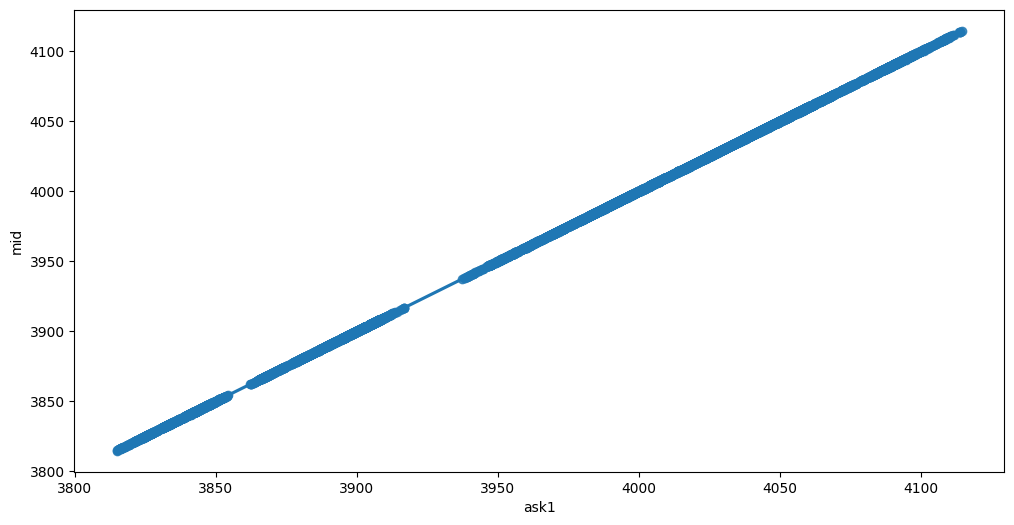

In [4]:
auto.dataset_overview(train_data=train, test_data=test, label='y')

## **Análisis de target**

## Target variable analysis

,count,mean,std,min,25%,50%,75%,max,dtypes,unique,missing_count,missing_ratio,raw_type,special_types
y,10000,0.37,0.482828,0.0,0.0,0.0,1.0,1.0,int64,2,,,int,


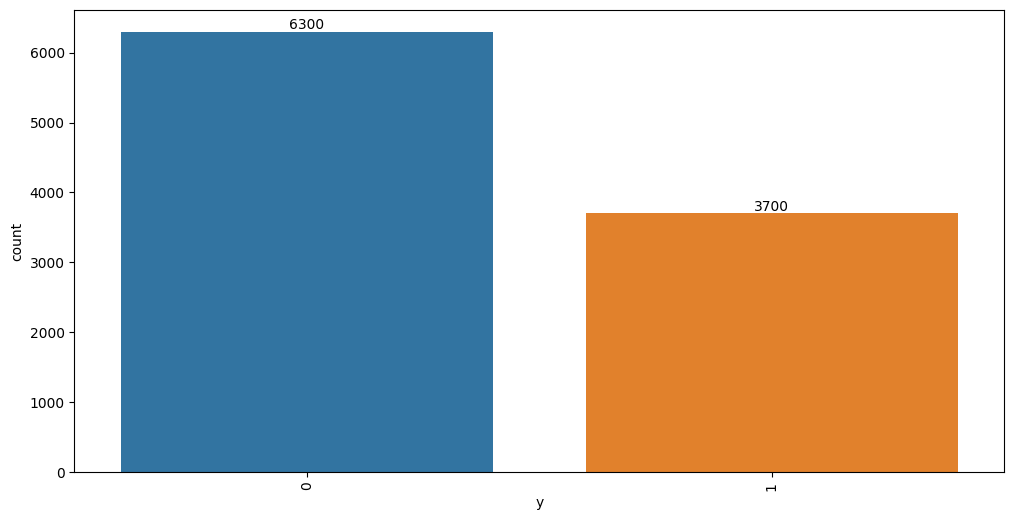

### Target variable correlations
 - ⚠️ no fields with absolute correlation greater than `0.5` found for target variable `y`.

: 

In [5]:
auto.target_analysis(train_data=train, label='y', )

## **Quickfit**

In [ ]:
auto.quick_fit(train, 'y', show_feature_importance_barplots=True)

## **Covariate Shift Analysis**

In [4]:
auto.covariate_shift_detection(train_data=train, test_data=test, label='y')    